# Example 5: Cell Death Signal

For the cell death analysis we are using PI stain to indicate the viability signal. For multi-cell interaction imaging, however, if both cell type dies we may hardly identify the signal is originated from which cell. To overcome the issue we suggest:

1. Channel weighted merging (ref: [example_1.ipynb](./example_1.ipynb))
2. Track cells with the segmentation mask from the merged image
3. Perform cross cell channel pixel correlation (pixelwise co-localization).
4. Identify death signal from the correlation map

Following demonstrates workflow to generate the csv file output.

In [1]:
from cyto.postprocessing.graph import *
from cyto.utils.label_to_table import *
import dask_image.imread
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import numpy as np
import pyclesperanto_prototype as cle
from skimage import exposure
import pandas as pd

## Load Image Files

In [2]:
#CANCER_IMAGE_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/roi/register_denoise_gamma/ch0/*.tif"
TCELL_IMAGE_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/roi/register_denoise_gamma/ch2/*.tif"

PI_IMAGE_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/roi/register_denoise_gamma/ch1/*.tif"

#CANCER_CORR_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/roi/register_denoise_gamma_cc/cancer/*.tif"
TCELL_CORR_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/roi/register_denoise_gamma_cc/tcell/*.tif"

#CANCER_LABEL_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/roi/register_denoise_gamma_channel_merged_masks/cancer/*.tif"
TCELL_LABEL_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/roi/register_denoise_gamma_channel_merged_masks/tcell/*.tif"

In [2]:
#TCELL_LABEL_PATH_PATTERN = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/roi/register_denoise_gamma_channel_merged_masks/tcell/*.tif"

In [29]:
# default chunk size: 1 image
# image_cancer = dask_image.imread.imread(CANCER_IMAGE_PATH_PATTERN)
image_tcell = dask_image.imread.imread(TCELL_IMAGE_PATH_PATTERN)

# pi_image = dask_image.imread.imread(PI_IMAGE_PATH_PATTERN)

# cancer_corr = dask_image.imread.imread(CANCER_CORR_PATH_PATTERN)
# tcell_corr = dask_image.imread.imread(TCELL_CORR_PATH_PATTERN)

# label_cancer = dask_image.imread.imread(CANCER_LABEL_PATH_PATTERN)
label_tcell = dask_image.imread.imread(TCELL_LABEL_PATH_PATTERN)

label_tcell

dask.array<_map_read_frame, shape=(8640, 1000, 1000), dtype=uint16, chunksize=(1, 1000, 1000), chunktype=numpy.ndarray>

In [30]:
BATCH = 3
BATCH_SIZE=2160
BEGIN_FRAME = BATCH_SIZE*BATCH
END_FRAME = BATCH_SIZE*(BATCH+1)-1 # define number of frames to perform killing analysis

In [31]:
print(BEGIN_FRAME,END_FRAME)

6480 8639


In [32]:
image_tcell=image_tcell[BEGIN_FRAME:END_FRAME+1,:,:].compute()

In [33]:
label_tcell=label_tcell[BEGIN_FRAME:END_FRAME+1,:,:].compute()

In [34]:
image_tcell_T = image_tcell.T

In [35]:
label_tcell_T = label_tcell.T

In [36]:
# convert segmentation mask to trackpy style array
features = {}
features_pi = {}
features_corr = {}

# note that pyCyto works in XYT dim order but dask/tiff is in TYX, need to transpose the array
# TODO: pixel spacing
# features["cancer"] = label_to_sparse(label=label_cancer[:FRAMES,:,:].T,image=image_cancer[:FRAMES,:,:].T,spacing=[1,1],channel_name="cancer")
# features["tcell"] = label_to_sparse(label=label_tcell_T,image=image_tcell_T,spacing=[1,1],channel_name="tcell")

# features_pi["cancer"] = label_to_sparse(label=label_cancer[:FRAMES,:,:].T,image=pi_image[:FRAMES,:,:].T,spacing=[1,1],channel_name="cancer_pi")
# features_pi["tcell"] = label_to_sparse(label=label_tcell[:FRAMES,:,:].T,image=pi_image[:FRAMES,:,:].T,spacing=[1,1],channel_name="tcell_pi")

# features_corr["cancer"] = label_to_sparse(label=label_cancer[:FRAMES,:,:].T,image=cancer_corr[:FRAMES,:,:].T,spacing=[1,1],channel_name="cancer_corr")
# features_corr["tcell"] = label_to_sparse(label=label_tcell[:FRAMES,:,:].T,image=tcell_corr[:FRAMES,:,:].T,spacing=[1,1],channel_name="tcell_corr")

features["tcell"] = label_to_sparse(label=label_tcell_T,spacing=[1,1],channel_name="tcell")



hello


Extracing segment features: 100%|██████████| 2160/2160 [06:34<00:00,  5.47it/s]


collecting data: 7384
collecting data: 7340
collecting data: 7430
collecting data: 7454
collecting data: 7405
collecting data: 7341
collecting data: 7346
collecting data: 7350
collecting data: 7399
collecting data: 7416
collecting data: 7471
collecting data: 7464
collecting data: 7483
collecting data: 7510
collecting data: 7532
collecting data: 7528
collecting data: 7537
collecting data: 7572
collecting data: 7541
collecting data: 7540
collecting data: 7527
collecting data: 7480
collecting data: 7470
collecting data: 7462
collecting data: 7431
collecting data: 7487
collecting data: 7449
collecting data: 7455
collecting data: 7467
collecting data: 7424
collecting data: 7378
collecting data: 7430
collecting data: 7405
collecting data: 7470
collecting data: 7443
collecting data: 7452
collecting data: 7464
collecting data: 7441
collecting data: 7437
collecting data: 7470
collecting data: 7474
collecting data: 7509
collecting data: 7474
collecting data: 7511
collecting data: 7534
collecting

100%|██████████| 2160/2160 [00:03<00:00, 644.45it/s]


## Concatenate Signals from Different Images

In [6]:
features["cancer"][["pi_mean","pi_median", "pi_std"]] = features_pi["cancer"][["mean","median", "sd"]] 
features["cancer"][["corr_mean","corr_median", "corr_std"]] = features_corr["cancer"][["mean","median", "sd"]] 

features["tcell"][["pi_mean","pi_median", "pi_std"]] = features_pi["tcell"][["mean","median", "sd"]] 
features["tcell"][["corr_mean","corr_median", "corr_std"]] = features_corr["tcell"][["mean","median", "sd"]] 

## Load Tracks 

Here the original ultrack tracking files are loaded. If the filtering death signal merging was already performed, there is an option below to load the signal concatenated and filtered Dataframe. 

In [7]:
# Load tracking file and merge with the death signal analysis table
TRACK_PATH = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/tracks/cancer_tracks/tracks/tracks_param_00000.csv"

tracks_df_cancer = pd.read_csv(TRACK_PATH)
tracks_df_cancer = tracks_df_cancer.sort_values(by=["t"])
tracks_df_cancer = tracks_df_cancer[(tracks_df_cancer["t"] < END_FRAME) & (tracks_df_cancer["t"] >= BEGIN_FRAME)]
tracks_df_cancer

,track_id,t,y,x,id,parent_track_id,parent_id
0,1,0,4.0,47.0,1000015,-1,-1
383285,1088,0,823.0,884.0,1008155,-1,-1
383165,1087,0,815.0,934.0,1008152,-1,-1
382805,1086,0,855.0,977.0,1008149,-1,-1
382538,1085,0,775.0,969.0,1008147,-1,-1
...,...,...,...,...,...,...,...
2835211,31276,1999,331.0,830.0,2000004022,-1,1999003981
2835272,31277,1999,341.0,818.0,2000004004,-1,1999003961
2835374,31279,1999,346.0,827.0,2000004012,-1,1999003973
2834807,31262,1999,164.0,159.0,2000001930,-1,1999001909


In [37]:
# Load tracking file and merge with the death signal analysis table
TRACK_PATH = "/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/tracks/tcell_tracks/tracks/20231017_roi-0_6480-8639_binT-1_tcell/tracks.csv"

tracks_df_tcell = pd.read_csv(TRACK_PATH)
tracks_df_tcell = tracks_df_tcell.sort_values(by=["t"])
tracks_df_tcell = tracks_df_tcell[(tracks_df_tcell["t"] < BATCH_SIZE) & (tracks_df_tcell["t"] >= 0)]
tracks_df_tcell.head()

,track_id,t,y,x,id,parent_track_id,parent_id
3476695,35207,0,8.0,77.0,1000015,-1,-1
3695831,36380,0,9.0,19.0,1002124,-1,-1
5624008,44843,0,439.0,158.0,1014128,-1,-1
8152651,56289,0,977.0,352.0,1030207,-1,-1
5623987,44842,0,442.0,149.0,1014127,-1,-1


Filter and map tcell tracks and signals

In [38]:
from sklearn.neighbors import KDTree

tcell_df = features["tcell"]

# iterate over frames
tcell_df_remapped = []
for t in tqdm(range(0,BATCH_SIZE),desc="Finding nearest cell"):
    tcell_t_df = tcell_df[tcell_df["frame"]==t]
    tracks_t_df = tracks_df_tcell[tracks_df_tcell["t"]==t]
    points_tcell = tcell_t_df[["y","x"]].values
    points_ultrack = tracks_t_df[["x","y"]].values

    try:
        # build KD-Tree for each point in ultrack df
        kdtree_ultrack = KDTree(points_ultrack)

        # query closest point for each point in t cell df
        dist, indices = kdtree_ultrack.query(points_tcell,k=1)

        dist = [d[0] for d in dist]
        indices = [i[0] for i in indices]

        remapped_track_ids = pd.DataFrame(tracks_t_df[["track_id","id"]].iloc[indices])
        remapped_track_ids["dist_from_ultrack"] = dist

        tcell_t_df.reset_index(drop=True,inplace=True)
        remapped_track_ids.reset_index(drop=True,inplace=True)
        tcell_t_df_remapped = pd.concat([tcell_t_df,remapped_track_ids],axis=1)

        tcell_df_remapped.append(tcell_t_df_remapped)
    except Exception as e:
        print("Error occured at t={}".format(t))
        print(e)

tcell_df_remapped = pd.concat(tcell_df_remapped)

track_pair_counts = tcell_df_remapped.groupby(["frame","track_id"]).size().reset_index(name="count")
filtered_rows = track_pair_counts[track_pair_counts['count'] != 1]

sorted_df = tcell_df_remapped.sort_values(by=["frame","track_id","dist_from_ultrack"])
sorted_df = sorted_df.drop_duplicates(subset=["frame","track_id"], keep="first")

sorted_df["tracked frames"] = sorted_df['frame'].groupby(sorted_df['track_id']).transform('count')
sorted_df['tracked length'] = sorted_df.groupby('track_id')['frame'].transform("max") - sorted_df.groupby('track_id')['frame'].transform("min") +1 

# filter out short tracks
min_track_length = 20
tracks_df_filtered_tcell = sorted_df[sorted_df["tracked length"] > min_track_length]

# filter by tracked average cell size
mean_transform = lambda x: x.mean()
tracks_df_filtered_tcell['mean tracked cell size'] = tracks_df_filtered_tcell.groupby("track_id")["size"].transform(mean_transform)

area_percentiles = tracks_df_filtered_tcell.sort_values("track_id")['mean tracked cell size'].quantile(0.95)

# filter out the cells with average area larger than threshold
tracks_df_filtered_tcell = tracks_df_filtered_tcell[tracks_df_filtered_tcell["mean tracked cell size"]<area_percentiles]
tracks_df_filtered_tcell

Finding nearest cell: 100%|██████████| 2160/2160 [00:54<00:00, 39.28it/s]
/tmp/ipykernel_150076/3449052174.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df_filtered_tcell['mean tracked cell size'] = tracks_df_filtered_tcell.groupby("track_id")["size"].transform(mean_transform)


,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size
1371,1372,76.845070,7.971831,4,72,9,11,7.971831,76.845070,4.0,...,0.0,0,tcell,NaN,35207,1000015,0.157470,98,98,71.622449
639,640,80.000000,18.078431,12,75,13,11,18.078431,80.000000,12.0,...,0.0,0,tcell,NaN,35214,1000016,0.078431,252,259,91.611111
4161,4162,79.461538,28.589744,25,77,8,6,28.589744,79.461538,25.0,...,0.0,0,tcell,NaN,35215,1000017,0.617518,114,114,34.578947
1414,1415,336.428571,2.514286,0,330,7,13,2.514286,336.428571,0.0,...,0.0,0,tcell,NaN,35216,1000024,0.647759,56,56,65.089286
1555,1556,437.119403,7.402985,3,433,10,10,7.402985,437.119403,3.0,...,0.0,0,tcell,NaN,35219,1000047,0.608838,30,30,56.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6837,16094374,874.375000,971.458333,969,872,6,6,971.458333,874.375000,969.0,...,0.0,2159,tcell,NaN,169566,2160030715,2.239947,291,293,27.790378
2845,16090382,893.479167,979.645833,976,889,8,9,979.645833,893.479167,976.0,...,0.0,2159,tcell,NaN,169570,2160030627,2.212849,235,272,54.714894
2717,16090254,896.979592,966.081633,962,894,9,8,966.081633,896.979592,962.0,...,0.0,2159,tcell,NaN,169579,2160030611,0.084145,296,297,45.141892
4083,16091620,684.075000,977.050000,974,681,7,7,977.050000,684.075000,974.0,...,0.0,2159,tcell,NaN,169581,2160031051,0.090139,117,124,44.239316


Filter and map cancer cell tracks and signals

In [10]:
from sklearn.neighbors import KDTree

cancer_df = features["cancer"]

# iterate over frames
cancer_df_remapped = []
for t in range(BEGIN_FRAME,END_FRAME+1):
    cancer_t_df = cancer_df[cancer_df["frame"]==t]
    tracks_t_df = tracks_df_cancer[tracks_df_cancer["t"]==t]
    points_cancer = cancer_t_df[["y","x"]].values
    points_ultrack = tracks_t_df[["x","y"]].values

    # build KD-Tree for each point in ultrack df
    kdtree_ultrack = KDTree(points_ultrack)

    # query closest point for each point in t cell df
    dist, indices = kdtree_ultrack.query(points_cancer,k=1)

    dist = [d[0] for d in dist]
    indices = [i[0] for i in indices]

    remapped_track_ids = pd.DataFrame(tracks_t_df[["track_id","id"]].iloc[indices])
    remapped_track_ids["dist_from_ultrack"] = dist

    cancer_t_df.reset_index(drop=True,inplace=True)
    remapped_track_ids.reset_index(drop=True,inplace=True)
    cancer_t_df_remapped = pd.concat([cancer_t_df,remapped_track_ids],axis=1)

    cancer_df_remapped.append(cancer_t_df_remapped)

cancer_df_remapped = pd.concat(cancer_df_remapped)

track_pair_counts = cancer_df_remapped.groupby(["frame","track_id"]).size().reset_index(name="count")
filtered_rows = track_pair_counts[track_pair_counts['count'] != 1]

sorted_df_cancer = cancer_df_remapped.sort_values(by=["frame","track_id","dist_from_ultrack"])
sorted_df_cancer = sorted_df_cancer.drop_duplicates(subset=["frame","track_id"], keep="first")

sorted_df_cancer["tracked frames"] = sorted_df_cancer['frame'].groupby(sorted_df_cancer['track_id']).transform('count')
sorted_df_cancer['tracked length'] = sorted_df_cancer.groupby('track_id')['frame'].transform("max") - sorted_df_cancer.groupby('track_id')['frame'].transform("min") +1 

# filter out short tracks
min_track_length = 20
tracks_df_filtered_cancer = sorted_df_cancer[sorted_df_cancer["tracked length"] > min_track_length]

# filter by tracked average cell size
mean_transform = lambda x: x.mean()
tracks_df_filtered_cancer['mean tracked cell size'] = tracks_df_filtered_cancer.groupby("track_id")["size"].transform(mean_transform)

area_percentiles = tracks_df_filtered_cancer.sort_values("track_id")['mean tracked cell size'].quantile(0.95)

# filter out the cells with average area larger than threshold
tracks_df_filtered_cancer = tracks_df_filtered_cancer[tracks_df_filtered_cancer["mean tracked cell size"]<area_percentiles]
tracks_df_filtered_cancer

/tmp/ipykernel_1499115/977165235.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tracks_df_filtered_cancer['mean tracked cell size'] = tracks_df_filtered_cancer.groupby("track_id")["size"].transform(mean_transform)


,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,pi_std,corr_mean,corr_median,corr_std,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size
749,750,47.236686,4.218935,0,38,12,22,4.218935,47.236686,0.0,...,405.286805,32835.147929,32650.320312,112.348398,1,1000015,0.322417,1412,1417,172.315864
337,338,39.313846,20.772308,11,30,21,20,20.772308,39.313846,11.0,...,173.434119,32757.003077,32650.320312,13.057210,2,1000016,0.387741,250,250,257.560000
643,644,68.674641,6.401914,0,61,16,17,6.401914,68.674641,0.0,...,109.183210,32737.842105,32650.320312,46.478686,3,1000065,0.517101,267,268,182.782772
442,443,103.872792,7.696113,0,94,17,20,7.696113,103.872792,0.0,...,386.760344,32876.250883,32905.679688,137.732668,4,1000067,0.329438,68,72,323.205882
533,534,99.112000,20.592000,14,88,16,26,20.592000,99.112000,14.0,...,533.552024,32887.816000,32905.679688,179.961258,5,1000068,0.423093,101,120,291.039604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,2604466,69.923664,422.412214,413,65,18,11,422.412214,69.923664,413.0,...,693.183917,32782.778626,32729.095703,56.724746,31996,2000004515,11.642913,20,21,117.350000
184,2603825,716.931478,622.372591,609,706,27,26,622.372591,716.931478,609.0,...,1388.669377,33012.182013,32837.123047,299.460185,32004,2000006405,0.631140,21,21,505.238095
1039,2604680,385.129870,608.363636,604,381,10,9,608.363636,385.129870,604.0,...,1750.822336,32733.090909,32729.095703,55.131943,32013,2000005637,0.386132,21,21,54.571429
672,2604313,291.460674,835.870787,829,283,15,17,835.870787,291.460674,829.0,...,2531.615643,32831.646067,32729.095703,204.283489,32030,2000008588,0.478453,18,21,176.722222


## Save filtered and signal merged dataframes for both celltypes

In [39]:
# save tracks
tracks_df_filtered_tcell.to_csv("/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/tracks/tcell_tracks/tracks/20231017_roi-0_6480-8639_binT-1_tcell/tcell_tracks_filtered_3.csv")
#tracks_df_filtered_cancer.to_csv("/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/tracks/cancer_tracks/tracks/cancer_tracks_filtered_signals.csv")

# Skip to here if the above merging and filtering was already performed

## Load filtered and merged dataframes

In [2]:
tracks_df_filtered_tcell = pd.read_csv("/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/tracks/tcell_tracks/tracks/tcell_tracks_filtered_signals.csv")
tracks_df_filtered_cancer = pd.read_csv("/mnt/Data/UTSE/2023_10_17_Nyeso1HCT116_1G4CD8_icam_FR10s_0p1mlperh/tracks/cancer_tracks/tracks/cancer_tracks_filtered_signals.csv")
tracks_df_filtered_tcell.drop("Unnamed: 0", axis=1, inplace=True)
tracks_df_filtered_cancer.drop("Unnamed: 0", axis=1, inplace=True)

In [13]:
tracks_df_filtered_tcell.columns

Index(['label', 'y', 'x', 'bbox_xstart', 'bbox_ystart', 'bbox_xsize',
       'bbox_ysize', 'i', 'j', 'bbox_istart', 'bbox_jstart', 'bbox_isize',
       'bbox_jsize', 'size', 'elongation', 'flatness', 'roundness',
       'feret_diameter', 'feret_radius', 'perimeter', 'mass', 'mean', 'median',
       'sd', 'frame', 'channel', 'alive', 'pi_mean', 'pi_median', 'pi_std',
       'corr_mean', 'corr_median', 'corr_std', 'track_id', 'id',
       'dist_from_ultrack', 'tracked frames', 'tracked length',
       'mean tracked cell size'],
      dtype='object')

In [88]:
features_corr["tcell"]

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,feret_diameter,feret_radius,perimeter,mass,mean,median,sd,frame,channel,alive
0,1,670.849246,390.738693,378,655,25,35,390.738693,670.849246,378.0,...,34.132096,17.066048,98.907157,20072241.0,33621.844221,33161.039062,1302.823913,0,tcell_corr,NaN
1,2,132.066532,630.483871,618,116,24,32,630.483871,132.066532,618.0,...,31.400637,15.700318,90.537283,17696583.0,35678.594758,34948.554688,3220.117246,0,tcell_corr,NaN
2,3,274.956790,865.415638,851,264,30,23,865.415638,274.956790,851.0,...,30.675723,15.337862,84.293566,15967940.0,32855.843621,32650.320312,290.928950,0,tcell_corr,NaN
3,4,691.069930,680.552448,667,675,25,28,680.552448,691.069930,667.0,...,30.232433,15.116216,82.167409,14486015.0,33766.934732,33161.039062,1521.887311,0,tcell_corr,NaN
4,5,659.125874,729.431235,717,648,29,22,729.431235,659.125874,717.0,...,31.304952,15.652476,84.388851,14955096.0,34860.363636,33927.117188,2001.935140,0,tcell_corr,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4870517,4870518,84.600000,910.400000,909,83,4,4,910.400000,84.600000,909.0,...,4.242641,2.121320,13.502870,491637.0,32775.800000,32886.412109,2.366432,499,tcell_corr,NaN
4870518,4870519,328.600000,920.600000,919,327,4,4,920.600000,328.600000,919.0,...,4.242641,2.121320,13.502870,491616.0,32774.400000,32886.412109,2.261479,499,tcell_corr,NaN
4870519,4870520,787.400000,971.600000,970,786,4,4,971.600000,787.400000,970.0,...,4.242641,2.121320,13.502870,491662.0,32777.466667,32886.412109,2.614975,499,tcell_corr,NaN
4870520,4870521,790.400000,987.600000,986,789,4,4,987.600000,790.400000,986.0,...,4.242641,2.121320,13.502870,491663.0,32777.533333,32886.412109,2.386470,499,tcell_corr,NaN


## Plot Cell Signals Overtime

(-1000.0, 1000.0)

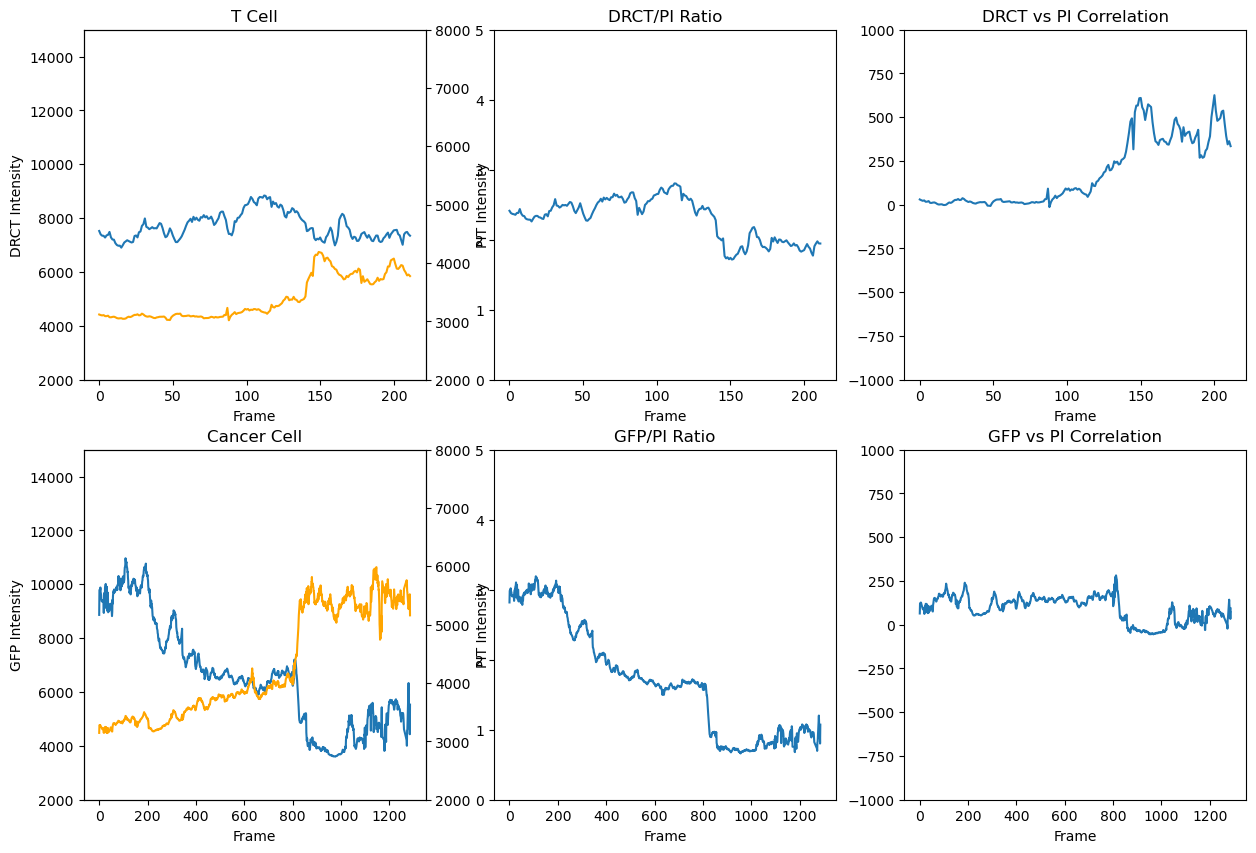

In [3]:
fig, axs = plt.subplots(2,3,figsize=(15,10))
axs=axs.ravel()

# isolate one cell
TRACK_ID_TCELL = 37

single_tcell_df = tracks_df_filtered_tcell.loc[tracks_df_filtered_tcell["track_id"]==TRACK_ID_TCELL]
single_tcell_df = single_tcell_df.sort_values(by=["frame"])

# isolate one cell
TRACK_ID_CANCER = 81

single_cancer_df = tracks_df_filtered_cancer.loc[tracks_df_filtered_cancer["track_id"]==TRACK_ID_CANCER]
single_cancer_df = single_cancer_df.sort_values(by=["frame"])

# t cell signal
axs[0].plot(single_tcell_df["frame"],single_tcell_df["mean"],label="DRCT")
axs_ = axs[0].twinx()
axs_.plot(single_tcell_df["frame"],single_tcell_df["pi_mean"],label="PI",color="orange")
axs[0].set_title("T Cell")
axs[0].set_xlabel("Frame")
axs[0].set_ylabel("DRCT Intensity")
axs[0].set_ylim([2000,15000])
axs_.set_ylabel("PIT Intensity")
axs_.set_ylim([2000,8000])

axs[1].plot(single_tcell_df["frame"],single_tcell_df["mean"]/single_tcell_df["pi_mean"])
axs[1].set_title("DRCT/PI Ratio")
axs[1].set_xlabel("Frame")
axs[1].set_ylim([0,5])

axs[2].plot(single_tcell_df["frame"],single_tcell_df["corr_mean"]-(2**16-1)//2)
axs[2].set_title("DRCT vs PI Correlation")
axs[2].set_xlabel("Frame")
axs[2].set_ylim([-1000,1000])

# cancer signal
axs[3].plot(single_cancer_df["frame"],single_cancer_df["mean"],label="GFP")
axs_ = axs[3].twinx()
axs_.plot(single_cancer_df["frame"],single_cancer_df["pi_mean"],label="PI",color="orange")
axs[3].set_title("Cancer Cell")
axs[3].set_xlabel("Frame")
axs[3].set_ylabel("GFP Intensity")
axs[3].set_ylim([2000,15000])
axs_.set_ylabel("PIT Intensity")
axs_.set_ylim([2000,8000])

axs[4].plot(single_cancer_df["frame"],single_cancer_df["mean"]/single_cancer_df["pi_mean"])
axs[4].set_title("GFP/PI Ratio")
axs[4].set_xlabel("Frame")
axs[4].set_ylim([0,5])

axs[5].plot(single_cancer_df["frame"],single_cancer_df["corr_mean"]-(2**16-1)//2)
axs[5].set_title("GFP vs PI Correlation")
axs[5].set_xlabel("Frame")
axs[5].set_ylim([-1000,1000])

Plot cell signal ratios over time

100%|██████████| 10/10 [00:00<00:00, 116.98it/s]


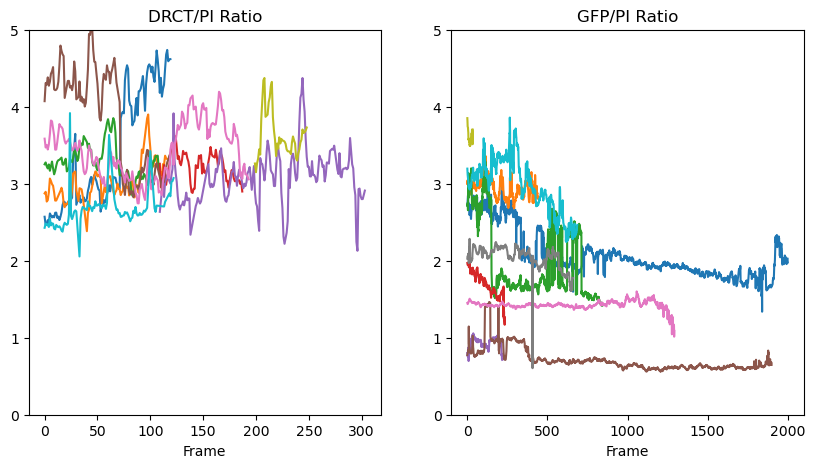

In [9]:
fig, axs = plt.subplots(1,2,figsize=(10,5))

for t_id in tqdm(range(100, 110)):
    single_tcell_df = tracks_df_filtered_tcell.loc[tracks_df_filtered_tcell["track_id"]==t_id]
    single_tcell_df = single_tcell_df.sort_values(by=["frame"])

    axs[0].plot(single_tcell_df["frame"],single_tcell_df["mean"]/single_tcell_df["pi_mean"])
    axs[0].set_title("DRCT/PI Ratio")
    axs[0].set_xlabel("Frame")
    axs[0].set_ylim([0,5])

    single_cancer_df = tracks_df_filtered_cancer.loc[tracks_df_filtered_cancer["track_id"]==t_id]
    single_cancer_df = single_cancer_df.sort_values(by=["frame"])

    axs[1].plot(single_cancer_df["frame"],single_cancer_df["mean"]/single_cancer_df["pi_mean"])
    axs[1].set_title("GFP/PI Ratio")
    axs[1].set_xlabel("Frame")
    axs[1].set_ylim([0,5])

## Brightness analysis

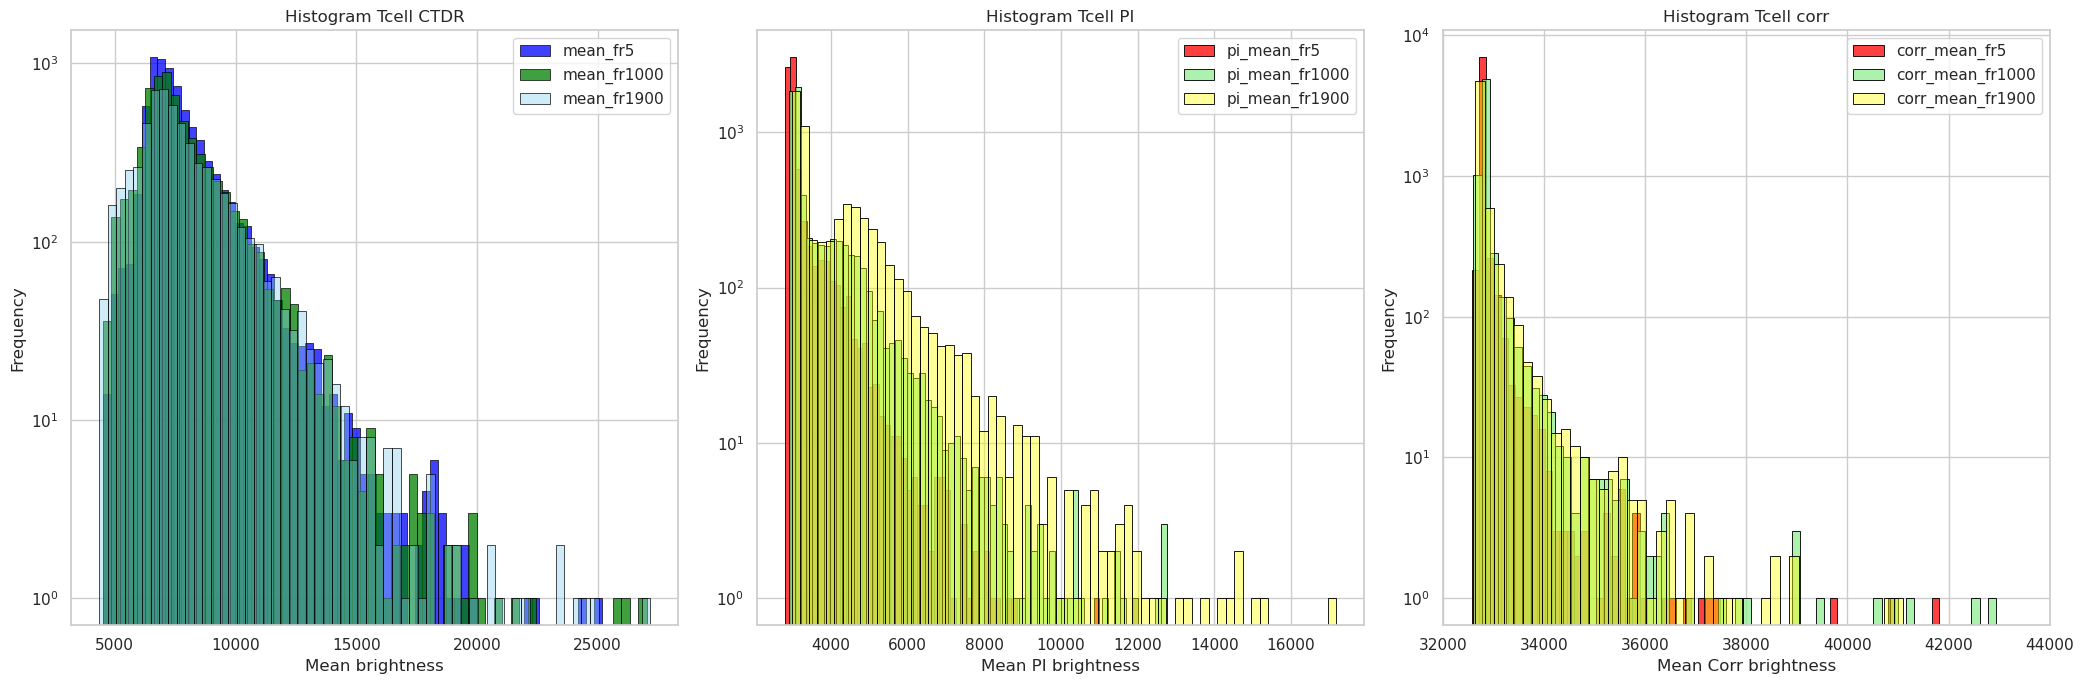

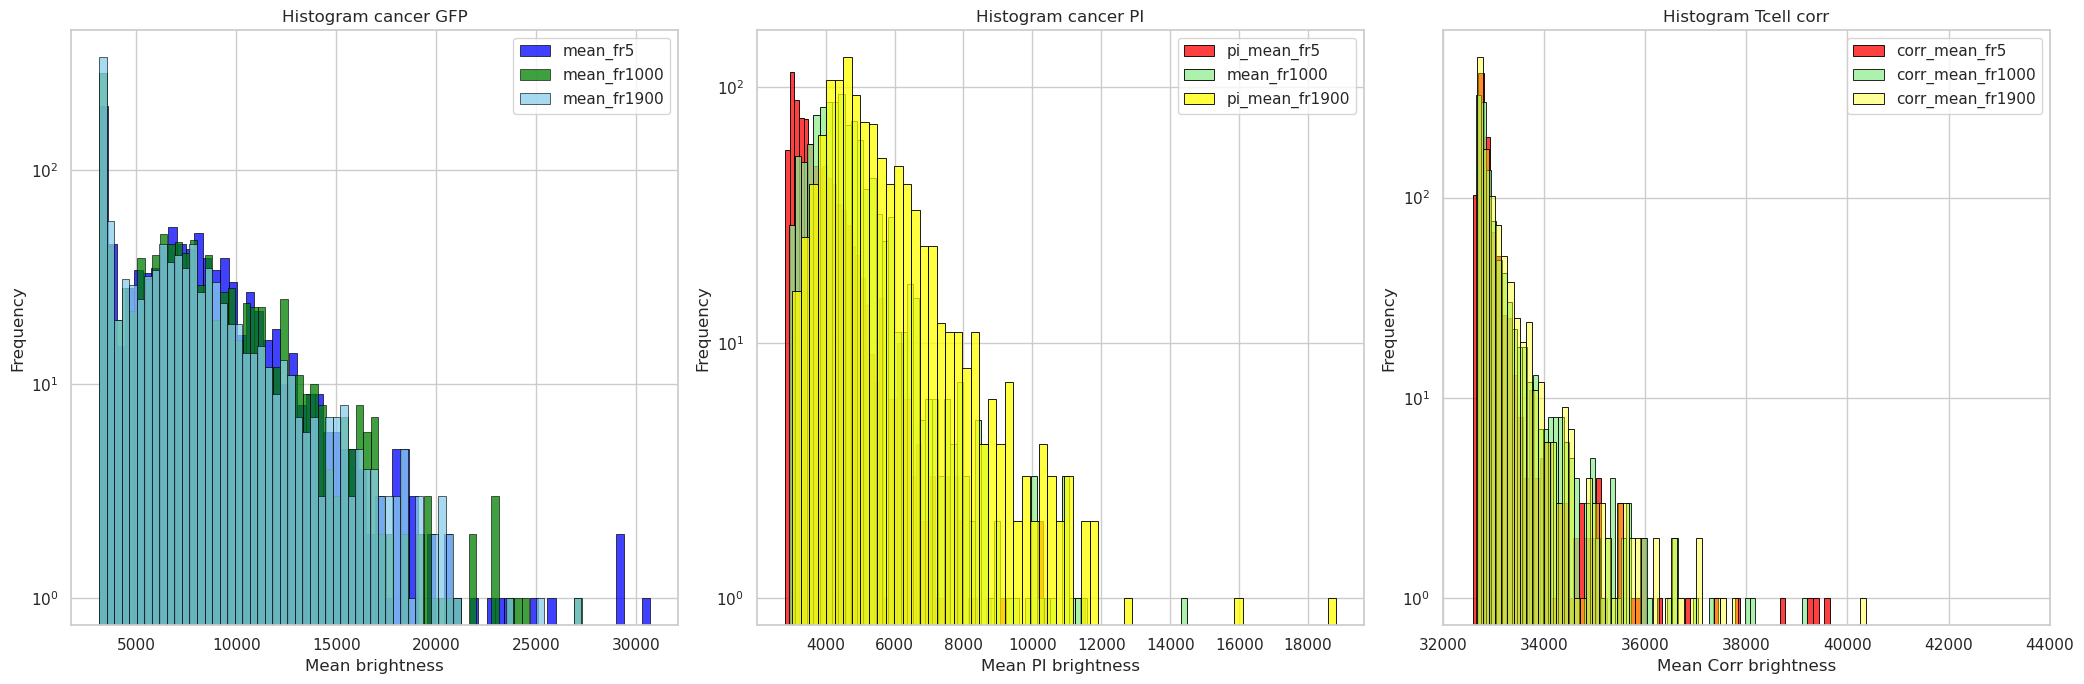

In [68]:
import seaborn as sns

#axs.set_xlim(0,3)
#axs.set_ylim(0,125)
# Set Seaborn style
sns.set(style='whitegrid')

tracks_df_filtered_tcell_bright_5 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==5]
tracks_df_filtered_tcell_bright_1000 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==1000]
tracks_df_filtered_tcell_bright_1500 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==1900]

tracks_df_filtered_tcell_corr_5 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==5]
tracks_df_filtered_tcell_corr_1000 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==1000]
tracks_df_filtered_tcell_corr_1500 = tracks_df_filtered_tcell[tracks_df_filtered_tcell["frame"]==1900]


tracks_df_filtered_cancer_bright_5 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==5]
tracks_df_filtered_cancer_bright_1000 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==1000]
tracks_df_filtered_cancer_bright_1500 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==1900]

tracks_df_filtered_cancer_corr_5 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==5]
tracks_df_filtered_cancer_corr_1000 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==1000]
tracks_df_filtered_cancer_corr_1500 = tracks_df_filtered_cancer[tracks_df_filtered_cancer["frame"]==1900]



# Plot tcell histogram
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
axes = axes.flatten()
sns.histplot(data=tracks_df_filtered_tcell_bright_5, x='mean', bins=64, kde=False, color='blue', edgecolor='black',ax=axes[0], label='mean_fr5')
sns.histplot(data=tracks_df_filtered_tcell_bright_1000, x='mean', bins=64, kde=False, color='green', edgecolor='black',ax=axes[0], label='mean_fr1000')
sns.histplot(data=tracks_df_filtered_tcell_bright_1500, x='mean', bins=64, kde=False, color='skyblue', edgecolor='black', label='mean_fr1900',ax=axes[0],alpha=0.4)
axes[0].set_title('Histogram Tcell CTDR')
axes[0].set_xlabel("Mean brightness")
axes[0].set_ylabel("Frequency")
axes[0].set_yscale("log")
axes[0].legend()
plt.tight_layout()

# Plot a histogram
sns.histplot(data=tracks_df_filtered_tcell_bright_5, x='pi_mean', bins=64, kde=False, color='red', edgecolor='black', ax=axes[1],label='pi_mean_fr5')
sns.histplot(data=tracks_df_filtered_tcell_bright_1000, x='pi_mean', bins=64, kde=False, color='lightgreen', edgecolor='black', ax=axes[1],label='pi_mean_fr1000')
sns.histplot(data=tracks_df_filtered_tcell_bright_1500, x='pi_mean', bins=64, kde=False, color="yellow", edgecolor='black', ax=axes[1], label='pi_mean_fr1900', alpha=0.4)
axes[1].set_title('Histogram Tcell PI')
axes[1].set_xlabel("Mean PI brightness")
axes[1].set_ylabel("Frequency")
axes[1].set_yscale("log")
axes[1].legend()

# Plot a histogram
sns.histplot(data=tracks_df_filtered_tcell_corr_5, x='corr_mean', bins=64, kde=False, color='red', edgecolor='black', ax=axes[2],label='corr_mean_fr5')
sns.histplot(data=tracks_df_filtered_tcell_corr_1000, x='corr_mean', bins=64, kde=False, color='lightgreen', edgecolor='black', ax=axes[2],label='corr_mean_fr1000')
sns.histplot(data=tracks_df_filtered_tcell_corr_1500, x='corr_mean', bins=64, kde=False, color="yellow", edgecolor='black', ax=axes[2], label='corr_mean_fr1900', alpha=0.4)
axes[2].set_title('Histogram Tcell corr')
axes[2].set_xlabel("Mean Corr brightness")
axes[2].set_ylabel("Frequency")
axes[2].set_yscale("log")
axes[2].set_xlim([32000,44000])
axes[2].legend()

plt.tight_layout()


#### Plot cancer histogram
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
axes = axes.flatten()
sns.histplot(data=tracks_df_filtered_cancer_bright_5, x='mean', bins=64, kde=False, color='blue', edgecolor='black', label='mean_fr5', ax=axes[0])
sns.histplot(data=tracks_df_filtered_cancer_bright_1000, x='mean', bins=64, kde=False, color='green', edgecolor='black', label='mean_fr1000', ax=axes[0])
sns.histplot(data=tracks_df_filtered_cancer_bright_1500, x='mean', bins=64, kde=False, color='skyblue', edgecolor='black', label='mean_fr1900', ax=axes[0])
axes[0].set_title('Histogram cancer GFP')
axes[0].set_xlabel("Mean brightness")
axes[0].set_ylabel("Frequency")
axes[0].set_yscale("log")
axes[0].legend()
plt.tight_layout()

# Plot a histogram
sns.histplot(data=tracks_df_filtered_cancer_bright_5, x='pi_mean', bins=64, kde=False, color='red', edgecolor='black', label='pi_mean_fr5', ax=axes[1])
sns.histplot(data=tracks_df_filtered_cancer_bright_1000, x='pi_mean', bins=64, kde=False, color='lightgreen', edgecolor='black', label='mean_fr1000', ax=axes[1])
sns.histplot(data=tracks_df_filtered_cancer_bright_1500, x='pi_mean', bins=64, kde=False, color='yellow', edgecolor='black', label='pi_mean_fr1900', ax=axes[1])
axes[1].set_title('Histogram cancer PI')
axes[1].set_xlabel("Mean PI brightness")
axes[1].set_ylabel("Frequency")
axes[1].set_yscale("log")
axes[1].legend()

# Plot a histogram
sns.histplot(data=tracks_df_filtered_cancer_corr_5, x='corr_mean', bins=64, kde=False, color='red', edgecolor='black', ax=axes[2],label='corr_mean_fr5')
sns.histplot(data=tracks_df_filtered_cancer_corr_1000, x='corr_mean', bins=64, kde=False, color='lightgreen', edgecolor='black', ax=axes[2],label='corr_mean_fr1000')
sns.histplot(data=tracks_df_filtered_cancer_corr_1500, x='corr_mean', bins=64, kde=False, color="yellow", edgecolor='black', ax=axes[2], label='corr_mean_fr1900', alpha=0.4)
axes[2].set_title('Histogram Tcell corr')
axes[2].set_xlabel("Mean Corr brightness")
axes[2].set_ylabel("Frequency")
axes[2].set_yscale("log")
axes[2].set_xlim([32000,44000])
axes[2].legend()



plt.tight_layout()
